# 1. Load Train Image

In [2]:
import numpy as np
import tensorflow as tf

In [5]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #GPU_ID from earlier

config = tf.compat.v1.ConfigProto(log_device_placement=True)
sess = tf.compat.v1.Session(config=config)

config.gpu_options.per_process_gpu_memory_fraction = 0.85

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
X_train = np.load('./test_set/X_train.npy')
X_test = np.load('./test_set/X_test.npy')
X_valid = np.load('./test_set/X_valid.npy')

In [4]:
Y_train = np.load('./test_set/Y_train.npy')
Y_test = np.load('./test_set/Y_test.npy')
Y_valid = np.load('./test_set/Y_valid.npy')

# 2. Train VGGFace

In [3]:
from keras_vggface.vggface import VGGFace

In [5]:
vggface = VGGFace(model='vgg16', include_top=False, input_shape=(200, 200, 3), pooling='avg')

In [6]:
# make all pretrained weights stop update
for layer in vggface.layers:
    layer.trainable = False

In [4]:
vggface.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 200, 200, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 200, 200, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 100, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 100, 100, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 100, 100, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 50, 128)     

In [117]:
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.models import Model
import tensorflow as tf

model = Sequential([
    vggface, 
    Dense(1, 'sigmoid')
])

In [118]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_vgg16 (Functional)   (None, 512)               14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [119]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',patience=5)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(
    X_train,Y_train,
    epochs = 10,
    batch_size = 64,
    validation_data = (X_valid,Y_valid),
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/10
70/70 [==============================] - 114s 2s/step - loss: 1.3100 - accuracy: 0.7478 - val_loss: 0.7265 - val_accuracy: 0.8277
Epoch 2/10
70/70 [==============================] - 113s 2s/step - loss: 0.5307 - accuracy: 0.8634 - val_loss: 0.4888 - val_accuracy: 0.8643
Epoch 3/10
70/70 [==============================] - 113s 2s/step - loss: 0.3617 - accuracy: 0.8958 - val_loss: 0.3783 - val_accuracy: 0.8920
Epoch 4/10
70/70 [==============================] - 113s 2s/step - loss: 0.2817 - accuracy: 0.9167 - val_loss: 0.3232 - val_accuracy: 0.9080
Epoch 5/10
70/70 [==============================] - 114s 2s/step - loss: 0.2472 - accuracy: 0.9259 - val_loss: 0.2965 - val_accuracy: 0.9089
Epoch 6/10
70/70 [==============================] - 113s 2s/step - loss: 0.2076 - accuracy: 0.9373 - val_loss: 0.2719 - val_accuracy: 0.9152
Epoch 7/10
70/70 [==============================] - 114s 2s/step - loss: 0.1801 - accuracy: 0.9433 - val_loss: 0.2491 - val_accuracy: 0.9196
Epoch 8/10
70

In [120]:
loss, acc = model.evaluate(X_test,Y_test)
print('\nLoss: {}, Acc: {}'.format(loss,acc))

44/44 [==============================] - 29s 669ms/step - loss: 0.1886 - accuracy: 0.9386

Loss: 0.18859349191188812, Acc: 0.9385714530944824


In [129]:
model.save('./test_set/pretrained_vggface.h5')

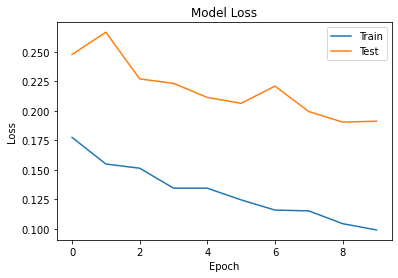

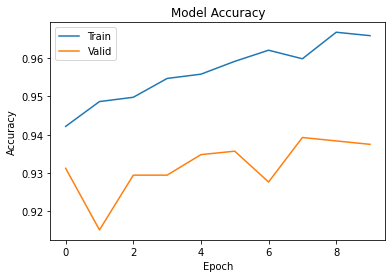

In [112]:
import matplotlib.pyplot as plt
def plt_show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'],loc=0)

def plt_show_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Valid'],loc=0)
plt_show_loss(history)
plt.show()
plt_show_acc(history)
plt.show()

In [113]:
from sklearn.metrics import classification_report
Y_pred = model.predict(X_test)
Y_pred = np.where(Y_pred>0.5, 1, 0)
print(classification_report(Y_test,Y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9421    0.9490    0.9455       686
         1.0     0.9506    0.9440    0.9473       714

    accuracy                         0.9464      1400
   macro avg     0.9464    0.9465    0.9464      1400
weighted avg     0.9465    0.9464    0.9464      1400



# 3-1. Test Model -> unchanged test set

In [69]:
ctz_original = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/frontal_ctz_original_4.npy')
mgs_original = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/frontal_mgs_original_4.npy')

In [121]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
original_img = np.append(ctz_original, mgs_original, axis=0)
y = np.append(np.zeros(shape=ctz_original.shape[0]), np.ones(shape=mgs_original.shape[0]), axis=0)

original_y_pred = model.predict(original_img)
original_y_pred = np.where(original_y_pred>0.5, 1, 0)
print(confusion_matrix(y,original_y_pred))

[[652  48]
 [ 41 659]]


In [122]:
print(classification_report(y,original_y_pred,digits=4))

              precision    recall  f1-score   support

         0.0     0.9408    0.9314    0.9361       700
         1.0     0.9321    0.9414    0.9367       700

    accuracy                         0.9364      1400
   macro avg     0.9365    0.9364    0.9364      1400
weighted avg     0.9365    0.9364    0.9364      1400



# 3-2. Test Model -> Skin changed set

In [72]:
ctz_skin_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/ctz_blacked/ctz_skin_changed_4.npy')
mgs_skin_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/mgs_whited/mgs_skin_changed_4.npy')

In [123]:
changed_img = np.append(ctz_skin_changed, mgs_skin_changed, axis=0)
y = np.append(np.zeros(shape=ctz_skin_changed.shape[0]), np.ones(shape=mgs_skin_changed.shape[0]), axis=0)

changed_y_pred = model.predict(changed_img)
changed_y_pred = np.where(changed_y_pred>0.5, 1, 0)

print(confusion_matrix(y,changed_y_pred))

[[686  14]
 [160 540]]


In [124]:
print(classification_report(y,changed_y_pred,digits=4))

              precision    recall  f1-score   support

         0.0     0.8109    0.9800    0.8875       700
         1.0     0.9747    0.7714    0.8612       700

    accuracy                         0.8757      1400
   macro avg     0.8928    0.8757    0.8743      1400
weighted avg     0.8928    0.8757    0.8743      1400



# 3-3. Test Model -> Nose changed set

In [75]:
ctz_nose_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/ctz_blacked/ctz_nose_changed_4.npy')
mgs_nose_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/mgs_whited/mgs_nose_changed_4.npy')

In [125]:
changed_img = np.append(ctz_nose_changed, mgs_nose_changed, axis=0)
y = np.append(np.zeros(shape=ctz_nose_changed.shape[0]), np.ones(shape=mgs_nose_changed.shape[0]), axis=0)

changed_y_pred = model.predict(changed_img)
changed_y_pred = np.where(changed_y_pred>0.5, 1, 0)

print(confusion_matrix(y,changed_y_pred))

[[673  27]
 [ 78 622]]


In [126]:
print(classification_report(y,changed_y_pred,digits=4))

              precision    recall  f1-score   support

         0.0     0.8961    0.9614    0.9276       700
         1.0     0.9584    0.8886    0.9222       700

    accuracy                         0.9250      1400
   macro avg     0.9273    0.9250    0.9249      1400
weighted avg     0.9273    0.9250    0.9249      1400



# 3-4. Test Model -> Lip changed set

In [81]:
ctz_lip_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/ctz_blacked/ctz_lip_changed_4.npy')
mgs_lip_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/mgs_whited/mgs_lip_changed_4.npy')

In [127]:
changed_img = np.append(ctz_lip_changed, mgs_lip_changed, axis=0)
y = np.append(np.zeros(shape=ctz_lip_changed.shape[0]), np.ones(shape=mgs_lip_changed.shape[0]), axis=0)

changed_y_pred = model.predict(changed_img)
changed_y_pred = np.where(changed_y_pred>0.5, 1, 0)

print(confusion_matrix(y,changed_y_pred))

[[662  38]
 [ 68 632]]


In [128]:
print(classification_report(y,changed_y_pred,digits=4))

              precision    recall  f1-score   support

         0.0     0.9068    0.9457    0.9259       700
         1.0     0.9433    0.9029    0.9226       700

    accuracy                         0.9243      1400
   macro avg     0.9251    0.9243    0.9243      1400
weighted avg     0.9251    0.9243    0.9243      1400



# 3-5. Test Model -> total changed set

In [78]:
ctz_total_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/ctz_blacked/ctz_total_changed_4.npy')
mgs_total_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/mgs_whited/mgs_total_changed_4.npy')

In [130]:
changed_img = np.append(ctz_total_changed, mgs_total_changed, axis=0)
y = np.append(np.zeros(shape=ctz_total_changed.shape[0]), np.ones(shape=mgs_total_changed.shape[0]), axis=0)

changed_y_pred = model.predict(changed_img)
changed_y_pred = np.where(changed_y_pred>0.5, 1, 0)

print(confusion_matrix(y,changed_y_pred))

[[694   6]
 [208 492]]


In [131]:
print(classification_report(y,changed_y_pred,digits=4))

              precision    recall  f1-score   support

         0.0     0.7694    0.9914    0.8664       700
         1.0     0.9880    0.7029    0.8214       700

    accuracy                         0.8471      1400
   macro avg     0.8787    0.8471    0.8439      1400
weighted avg     0.8787    0.8471    0.8439      1400

